# Multi-layer perceptron classifier
### Regions of voice activity labelled as 1 (labels 1-7); otherwise 0 (labels 8,C,I,X)
### Following code is trained and tested on only z007

In [1]:
import pickle as pkl
from config import path_to_save, spectrogram_specs, mlp_specs
import os
import numpy as np
import random
import librosa
from keras.utils import to_categorical
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
bird_id,days = pkl.load(open(path_to_save+"zf_recordings.pkl","rb"))

In [3]:
bird_ind = 0 #z007
print("Bird:",bird_id[bird_ind])

#load data from all the recordings for a bird
dirName = path_to_save+"spectrograms/"+bird_id[bird_ind]+"/"
folders = os.listdir(dirName)

spectrograms = []
mel_spectrograms = []
labels = []
for i in folders:
    s = pkl.load(open(dirName+i+"/spectrograms.pkl","rb"))
    print("Day:",i,", No.of chunks:",len(s))
    spectrograms.extend(s)
    mel_spectrograms.extend(pkl.load(open(dirName+i+"/mel_spectrograms.pkl","rb")))
    labels.extend(pkl.load(open(dirName+i+"/labels.pkl","rb")))
    
print("Total no. of spectrograms:",len(spectrograms))
print("Total no. of mel-spectrograms:",len(mel_spectrograms))
print("Total no. of labels:",len(labels))
    

Bird: z007
Day: day-2016-09-09 , No.of chunks: 5
Day: day-2016-09-10 , No.of chunks: 14
Day: day-2016-09-11 , No.of chunks: 20
Day: day-2016-09-13 , No.of chunks: 5
Total no. of spectrograms: 44
Total no. of mel-spectrograms: 44
Total no. of labels: 44


# Load config file and set input size for MLP

In [4]:
fft_center = spectrogram_specs["fft_center"]
window = spectrogram_specs["window"]
stride = spectrogram_specs["stride"]

if fft_center:
    pad = window/2
else:
    pad = 0
    
#input type - spectrogram or mel-spectrogram
input_type = mlp_specs["input_type"]
print("Input type:",input_type)

#time and equivalent no. of frames in audio space
input_window = mlp_specs["input_window"]
n_frames = input_window*spectrogram_specs["sr"]*1e-3
print("Context window (ms):",input_window)
print("Context window (frames):",n_frames)

#no. of frames in spectrogram space
avg_window = int((n_frames - window + (2*pad))/stride + 1)
print("Context window in spectrogram space (frames):",avg_window)

#input shape
if input_type == "spectrogram":
    print("Spectrogram length (no. of freq bins):",len(spectrograms[0]))
    input_shape = avg_window*len(spectrograms[0])
elif input_type == "mel_spectrogram":
    print("Mel-Spectrogram length (no. of freq bins):",len(mel_spectrograms[0]))
    input_shape = avg_window*len(mel_spectrograms[0])
else:
    print("Invalid input type")

Input type: mel_spectrogram
Context window (ms): 200
Context window (frames): 6000.0
Context window in spectrogram space (frames): 94
Mel-Spectrogram length (no. of freq bins): 32


# Dataset creation with equal data points per class
### Equal distribution obtained by random sampling of data points
#### Remove "index%sample_stride == 0" in line 8 and 9 to consider all samples

In [5]:
x_0 = np.empty((0,input_shape))
x_1 = np.empty((0,input_shape))
y_org = []
sample_stride = 10
for i in range(len(spectrograms)):
    print("Chunk:",i)
    ind_1 = [index for index, element in enumerate(labels[i]["frame_labels"]) 
             if element not in [8,'C','I','X'] and index > avg_window and index%sample_stride == 0]
    ind_0 = [index for index, element in enumerate(labels[i]["frame_labels"]) 
             if element in [8,'C','I','X'] and index > avg_window and index%sample_stride == 0]
    ind_0 = random.sample(ind_0,len(ind_1))
    print("0:",len(ind_0),"1:",len(ind_1))

    #------------------------------------------------------------
    #normalize to dB at the chunk level 
    if input_type == "spectrogram":
        S = librosa.power_to_db(spectrograms[i])
    elif input_type == "mel_spectrogram":
        S = librosa.power_to_db(mel_spectrograms[i])
    else:
        print("Invalid input type")
    #------------------------------------------------------------

    for j in ind_0:
        x_0 = np.append(x_0,np.reshape(S[:,j-avg_window:j],(1,avg_window*np.shape(S)[0])),axis=0)
    for j in ind_1:
        x_1 = np.append(x_1,np.reshape(S[:,j-avg_window:j],(1,avg_window*np.shape(S)[0])),axis=0)

print("X_shape:",np.shape(x_0),np.shape(x_1))


Chunk: 0
0: 279 1: 279
Chunk: 1
0: 69 1: 69
Chunk: 2
0: 69 1: 69
Chunk: 3
0: 105 1: 105
Chunk: 4
0: 321 1: 321
Chunk: 5
0: 167 1: 167
Chunk: 6
0: 277 1: 277
Chunk: 7
0: 267 1: 267
Chunk: 8
0: 103 1: 103
Chunk: 9
0: 170 1: 170
Chunk: 10
0: 107 1: 107
Chunk: 11
0: 237 1: 237
Chunk: 12
0: 149 1: 149
Chunk: 13
0: 275 1: 275
Chunk: 14
0: 104 1: 104
Chunk: 15
0: 103 1: 103
Chunk: 16
0: 67 1: 67
Chunk: 17
0: 169 1: 169
Chunk: 18
0: 240 1: 240
Chunk: 19
0: 240 1: 240
Chunk: 20
0: 173 1: 173
Chunk: 21
0: 305 1: 305
Chunk: 22
0: 174 1: 174
Chunk: 23
0: 174 1: 174
Chunk: 24
0: 109 1: 109
Chunk: 25
0: 206 1: 206
Chunk: 26
0: 240 1: 240
Chunk: 27
0: 179 1: 179
Chunk: 28
0: 67 1: 67
Chunk: 29
0: 132 1: 132
Chunk: 30
0: 148 1: 148
Chunk: 31
0: 174 1: 174
Chunk: 32
0: 173 1: 173
Chunk: 33
0: 174 1: 174
Chunk: 34
0: 142 1: 142
Chunk: 35
0: 172 1: 172
Chunk: 36
0: 209 1: 209
Chunk: 37
0: 106 1: 106
Chunk: 38
0: 180 1: 180
Chunk: 39
0: 178 1: 178
Chunk: 40
0: 202 1: 202
Chunk: 41
0: 172 1: 172
Chunk: 42


# Train, Val and Test split

In [6]:
def split_data(x_0,x_1,p_train,p_val,p_test,mode):
    if mode == "train":
        start_ind = 0
        end_ind = int(p_train*np.shape(x_0)[0])
        p = p_train
    elif mode == "val":
        start_ind = int(p_train*np.shape(x_0)[0])
        end_ind = int(p_train*np.shape(x_0)[0])+int(p_val*np.shape(x_0)[0])
        p = p_val
    else:
        start_ind = np.shape(x_0)[0] - int(p_test*np.shape(x_0)[0])
        end_ind = np.shape(x_0)[0]
        p = p_test
        
    print("Mode:",mode)
    print("per class, start_ind:",start_ind,"end_ind:",end_ind)  
    
    x = np.append(x_0[start_ind:end_ind,:],x_1[start_ind:end_ind,:],axis=0)
    y = to_categorical(np.append([0]*int(p*np.shape(x_0)[0]),[1]*int(p*np.shape(x_1)[0]),axis=0))
    
    print("X_shape:",np.shape(x))
    print("Y_shape:",np.shape(y))
    
    c = list(zip(x, y))
    random.shuffle(c)
    x,y= zip(*c)
    return np.array(x), np.array(y)

In [7]:
#percentage train, val, test
p_train = mlp_specs["p_train"]
p_val = mlp_specs["p_val"]
p_test = mlp_specs["p_test"]

x_train,y_train = split_data(x_0,x_1,p_train,p_val,p_test,"train")
x_val,y_val = split_data(x_0,x_1,p_train,p_val,p_test,"val")
x_test,y_test = split_data(x_0,x_1,p_train,p_val,p_test,"val")

Mode: train
per class, start_ind: 0 end_ind: 4548
X_shape: (9096, 3008)
Y_shape: (9096, 2)
Mode: val
per class, start_ind: 4548 end_ind: 6064
X_shape: (3032, 3008)
Y_shape: (3032, 2)
Mode: val
per class, start_ind: 4548 end_ind: 6064
X_shape: (3032, 3008)
Y_shape: (3032, 2)


# Normalization

In [8]:
mu = np.mean(x_train,axis=0)
sigma = np.std(x_train,axis=0)
print("Mu shape:",np.shape(mu),"Sigma shape:",np.shape(sigma))

def normalize(x,mu,sigma):
    x = (x-mu)/sigma
    return x

x_train = normalize(x_train,mu,sigma)
x_val = normalize(x_val,mu,sigma)
x_test = normalize(x_test,mu,sigma)


Mu shape: (3008,) Sigma shape: (3008,)


# Model

In [9]:
from keras import Model
from keras.layers import Input, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [10]:
#model architecture
input = Input(shape=(input_shape,))
dense1 = Dense(64, activation = "relu")(input)
output = Dense(1, activation = "sigmoid")(dense1)

model = Model(input,output)
model.summary()

model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3008)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                192576    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 192,641
Trainable params: 192,641
Non-trainable params: 0
_________________________________________________________________


In [11]:
#checkpoint and earlystopping
model_path = mlp_specs["path_to_save"]
model_name = input_type + "_window_" + str(input_window)
print(model_path+model_name)

if not os.path.exists(model_path):
    os.mkdir(model_path)
    
checkpoint = ModelCheckpoint(
    model_path+model_name+"_model.h5",
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto")

earlystop = EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=6,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

/home/aparna/mlp/mel_spectrogram_window_200


In [12]:
#train model, save model and history
history = model.fit(x_train,np.argmax(y_train,axis=1),
         validation_data = (x_val,np.argmax(y_val,axis=1)),
         batch_size = 32,
         epochs = 100,
         callbacks = [earlystop,checkpoint])

pkl.dump(history.history,open(model_path+model_name+"_history.pkl","wb"))

Train on 9096 samples, validate on 3032 samples
Epoch 1/100
9096/9096 [==============================] - 1s 74us/step - loss: 0.1850 - accuracy: 0.9540 - val_loss: 0.2070 - val_accuracy: 0.9324
Epoch 2/100
9096/9096 [==============================] - 1s 67us/step - loss: 0.0681 - accuracy: 0.9779 - val_loss: 0.6503 - val_accuracy: 0.8318
Epoch 3/100
9096/9096 [==============================] - 1s 58us/step - loss: 0.1020 - accuracy: 0.9760 - val_loss: 0.1138 - val_accuracy: 0.9657
Epoch 4/100
9096/9096 [==============================] - 1s 65us/step - loss: 0.0357 - accuracy: 0.9868 - val_loss: 0.0937 - val_accuracy: 0.9743
Epoch 5/100
9096/9096 [==============================] - 1s 65us/step - loss: 0.0331 - accuracy: 0.9897 - val_loss: 0.2458 - val_accuracy: 0.9522
Epoch 6/100
9096/9096 [==============================] - 1s 66us/step - loss: 0.0388 - accuracy: 0.9888 - val_loss: 0.2227 - val_accuracy: 0.9456
Epoch 7/100
9096/9096 [==============================] - 1s 63us/step - loss

# Testing

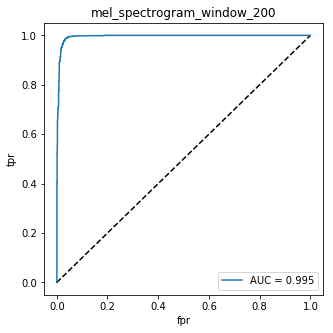

In [13]:
model = load_model(model_path+model_name+"_model.h5")

y_pred= model.predict(x_test).ravel()
fpr, tpr, threshold = roc_curve(np.argmax(y_test, axis = 1), y_pred)
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr,label="AUC = {:.3f}".format(auc(fpr,tpr)))
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title(model_name)
plt.legend()
plt.show()
